In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (K*16*(N-1)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def td(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return (2*((i-j)**2))/h

def SHD_td(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = td(n)
    
    d = np.zeros(2)
    N = np.zeros(10)
    
    for k in range(10):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[6] > 0: N[6] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[2] > 0: N[2] -= 1
            elif N[4] > 0: N[4] -= 1
            elif N[8] > 0: N[8] -= 1
            elif N[1] > 0: N[1] -= 1
            elif N[0] > 0: N[0] -= 1
            elif N[7] > 0: N[7] -= 1
            else: N[3] -= 1
            N[9] += 1
            
            T = td(N)
            d[0] -= 1
        
        T = td(n)
        for k in range(10):
            N[k] = n[k]
        
        while T < cc:
            if N[9] > 0: N[9] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[3] > 0: N[3] -= 1
            elif N[4] > 0: N[4] -= 1
            elif N[8] > 0: N[8] -= 1
            elif N[1] > 0: N[1] -= 1
            elif N[0] > 0: N[0] -= 1
            elif N[5] > 0: N[5] -= 1
            else: N[2] -= 1
            N[6] += 1
            
            T = td(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
        
    else:
        step = 0
        
        for k in range(10):
            N[k] = n[k]
            
        if i > j:
            while T >= cc:
                if N[9] > 0: N[9] -= 1
                elif N[3] > 0: N[3] -= 1
                elif N[7] > 0: N[7] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[1] > 0: N[1] -= 1
                elif N[4] > 0: N[4] -= 1
                elif N[8] > 0: N[8] -= 1
                elif N[2] > 0: N[2] -= 1
                else: N[5] -= 1
                N[6] += 1
                
                T = td(N)
                step += 1
        else:
            while T >= cc:
                if N[6] > 0: N[6] -= 1
                elif N[2] > 0: N[2] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[1] > 0: N[1] -= 1
                elif N[4] > 0: N[4] -= 1
                elif N[8] > 0: N[8] -= 1
                elif N[3] > 0: N[3] -= 1
                else: N[7] -= 1
                N[9] += 1
                
                T = td(N)
                step += 1
                
        return step-1

In [4]:
def appx_SHD_td(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = td(n)
    
    if T < cc:
        if h <= cc/2:
            return -math.ceil((cc-h-math.fabs(i-j))/4)
        else:
            return -math.ceil((math.sqrt(h*cc/2)-math.fabs(i-j))/4)
    else:
        return math.ceil((math.fabs(i-j)-math.sqrt(h*cc/2))/4) - 1

In [5]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

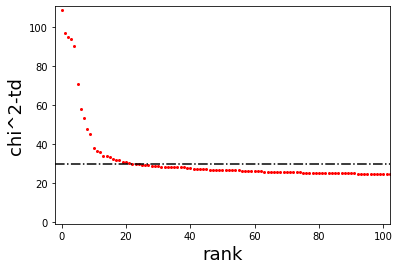

In [6]:
N = 5000
M = 1000000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    for j in range(10):
        S = 0
        for k in range(j):
            S += n[i][k]
        n[i][j] = np.random.binomial(2*N-S, 1/(10-j))
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

for i in range(M-10,M):
    for j in range(10):
        S = 0
        for k in range(j):
            S += n[i][k]
        if j == 2 or j == 5 or j == 6:
            n[i][j] = np.random.binomial(2*N-S, 1.14/(10-j))
        else:
            n[i][j] = np.random.binomial(2*N-S, 1/(10-j))
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = (2*((I[i]-J[i])**2))/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(29.7, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-td", fontsize = 18)
fig.savefig("stats-td.png")
fig.savefig("fig/stats-td.eps")

In [7]:
cc = 29.7
appx_shd = np.zeros(M)
shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_td(cc,k)
    shd[i] = SHD_td(cc,k)

print(appx_shd)
print(shd)

[ -79.  -91. -113. ...   40.   94.   46.]
[ -79.  -91. -113. ...   40.   94.   46.]


In [8]:
def rankError_Lap(data,epsilon, K, N, M):
    RE = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            RE += (noisy_rank[i]-i)
    RE /= (K*50)
    return RE

In [9]:
def rankError_Exp(x, appx_shd, shd, epsilon, K, N, M):
    RE = np.zeros(2)
    cc = 29.7
    
    #print(x)
        
    APPX = np.zeros(M)
    SHD = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
            SHD[i] = shd[i]
        
        #print(APPX)
        #print(SHD)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        exact_result = exp_mec(SHD, M, K, epsilon)
        #print(appx_result)
        #print(rank[int(appx_result[0])])
        #print(exact_result)
        for k in range(K):
            for l in range(M):
                if(appx_result[k] == x[M-1-l]):
                    RE[0] += math.fabs(k-l)
                    break
            for l in range(M):
                if(exact_result[k] == x[M-1-l]):
                    RE[1] += math.fabs(k-l)
                    break
    RE /= (K*50)
    return RE

In [10]:
K = 1
N = 5000
M = 1000000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[3.56644692e+05 2.47388836e+05 2.46592372e+05]
 [4.59821940e+04 1.44000000e-01 2.12000000e-01]
 [3.29384400e+03 0.00000000e+00 0.00000000e+00]
 [4.10400000e+00 0.00000000e+00 0.00000000e+00]
 [1.32000000e+00 0.00000000e+00 0.00000000e+00]
 [1.17200000e+00 0.00000000e+00 0.00000000e+00]
 [1.06800000e+00 0.00000000e+00 0.00000000e+00]]


In [11]:
K = 2
N = 5000
M = 1000000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.16720843e+05 3.70265106e+05 3.74913870e+05]
 [1.75993287e+05 1.09000000e+00 9.64000000e-01]
 [5.52591850e+04 5.72000000e-01 5.16000000e-01]
 [6.24325800e+03 2.56000000e-01 2.90000000e-01]
 [1.22390000e+02 1.60000000e-01 1.96000000e-01]
 [1.18900000e+01 1.08000000e-01 1.18000000e-01]
 [2.40600000e+00 6.00000000e-02 6.00000000e-02]]


In [12]:
K = 3
N = 5000
M = 1000000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.64151024e+05 4.08318597e+05 4.24434451e+05]
 [2.50882213e+05 1.38023213e+04 9.94904800e+03]
 [1.32678439e+05 8.28000000e-01 8.41333333e-01]
 [2.43966800e+04 5.14666667e-01 5.12000000e-01]
 [3.13077333e+03 3.98666667e-01 4.14666667e-01]
 [4.72473333e+02 3.05333333e-01 3.17333333e-01]
 [7.69306667e+01 2.56000000e-01 2.28000000e-01]]


In [13]:
K = 5
N = 5000
M = 1000000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.73822683e+05 4.46225738e+05 4.32646865e+05]
 [3.56930590e+05 2.32799853e+05 2.14577879e+05]
 [2.39740856e+05 1.18392080e+03 9.52792800e+02]
 [1.09555097e+05 7.86400000e-01 7.50400000e-01]
 [4.20030304e+04 6.40000000e-01 6.27200000e-01]
 [1.21886384e+04 4.40000000e-01 4.96000000e-01]
 [6.65897480e+03 3.80800000e-01 3.96800000e-01]]


In [14]:
K = 10
N = 5000
M = 1000000

RE = np.zeros((7,3))
sum_re = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[0]
        RE[i][2] = rankError_Exp(x,appx_shd,shd,epsilon[i],K,N,M)[1]
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.91914311e+05 4.81933253e+05 4.85179566e+05]
 [4.37606761e+05 3.69820275e+05 3.72606090e+05]
 [3.76885931e+05 2.24810326e+05 2.31004094e+05]
 [3.03653599e+05 1.51709556e+04 1.42928280e+04]
 [2.15624509e+05 3.82158800e+02 4.76527600e+02]
 [1.60631068e+05 1.70448000e+01 1.66692000e+01]
 [1.20434684e+05 8.05200000e-01 7.45600000e-01]]
